In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver


In [53]:
L0 = 1e-6;  #length unit: microns
wvlen = 0.47;  # wavelength in L0


Npml = np.array([0,0,0]);  # [Nx_pml Ny_pml]
xrange = 0.5*np.array([-1, 1]);  # x boundaries in L0
yrange = 0.5*np.array([-1, 1]);  # y boundaries in L0
zrange = 0.5*np.array([-1, 1]);
N = np.array([51,51,51])

In [54]:
## Set up the permittivity.
eps_r = np.ones(N)
print(eps_r.shape)
M = np.prod(N)
print(M)
#eps_r[8:12, 8:12, 8:12] = 6;

(51, 51, 51)
132651


In [55]:
## Set up the current source density.
Jz = np.zeros(N);
ind_src = (np.ceil(N/2).astype('int'));  # (i,j) indices of the center cell; Nx, Ny should be odd
print(ind_src)
Jz[ind_src[0], ind_src[1], ind_src[2]] = 1;
Jx = np.zeros(N);
Jy = np.zeros(N);
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r,
    'eps_zz': eps_r,
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}

[26 26 26]


In [56]:
## Wonsoek's scalar parameter 1, -1, or 0
s = -1;

In [57]:
dir(pyfd3d)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [58]:
import pyfd3d.fd3d as fd3d

In [59]:
print(wvlen, Npml)

0.47 [0 0 0]


In [60]:
A,b, Ch = fd3d.curlcurlE(L0, wvlen, xrange, yrange, zrange, eps_r_tensor_dict, JCurrentVector,Npml, s = -1)

(397953,)


In [61]:
print(A.count_nonzero())
print(A[0:100,0:100])

5969295
  (0, 0)	(1.2276642343748064e+16+0j)
  (0, 1)	(-2069810034910098.8+0j)
  (0, 50)	(-2069810034910098.8+0j)
  (0, 51)	(-2069810034910099+0j)
  (1, 0)	(-2069810034910098.8+0j)
  (1, 1)	(1.2276642343748064e+16+0j)
  (1, 2)	(-2069810034910098.8+0j)
  (1, 52)	(-2069810034910099+0j)
  (2, 1)	(-2069810034910098.8+0j)
  (2, 2)	(1.2276642343748064e+16+0j)
  (2, 3)	(-2069810034910098.8+0j)
  (2, 53)	(-2069810034910099+0j)
  (3, 2)	(-2069810034910098.8+0j)
  (3, 3)	(1.2276642343748064e+16+0j)
  (3, 4)	(-2069810034910098.8+0j)
  (3, 54)	(-2069810034910099+0j)
  (4, 3)	(-2069810034910098.8+0j)
  (4, 4)	(1.2276642343748064e+16+0j)
  (4, 5)	(-2069810034910098.8+0j)
  (4, 55)	(-2069810034910099+0j)
  (5, 4)	(-2069810034910098.8+0j)
  (5, 5)	(1.2276642343748064e+16+0j)
  (5, 6)	(-2069810034910098.8+0j)
  (5, 56)	(-2069810034910099+0j)
  (6, 5)	(-2069810034910098.8+0j)
  :	:
  (93, 93)	(1.2276642343748064e+16+0j)
  (93, 94)	(-2069810034910098.8+0j)
  (94, 43)	(-2069810034910099+0j)
  (94, 93)	(-2

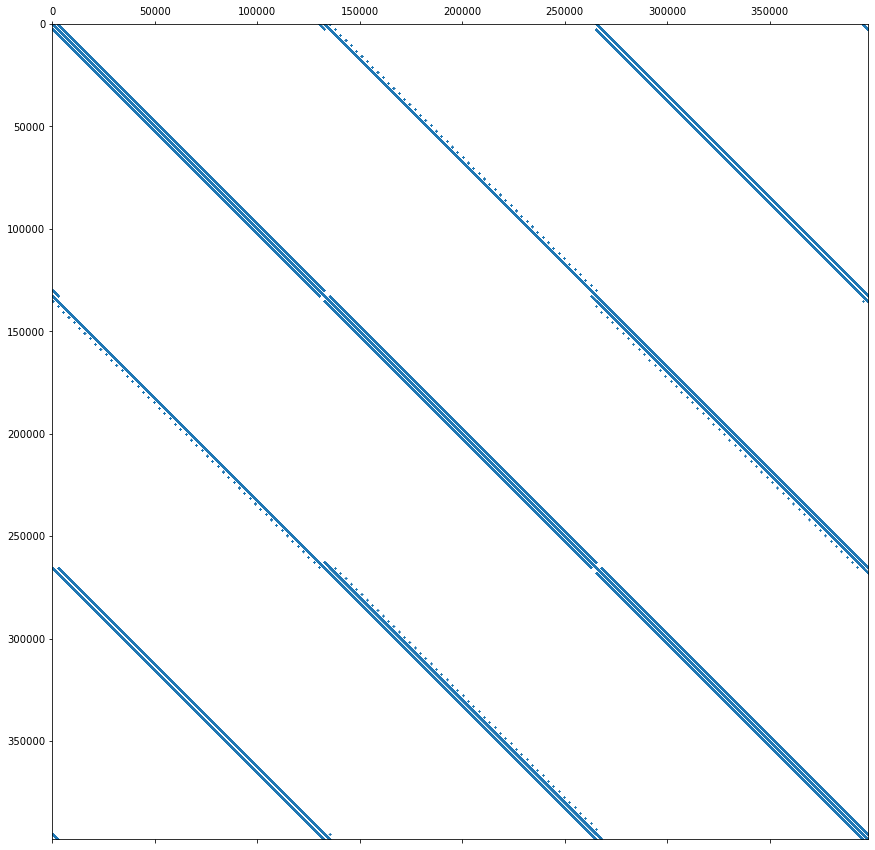

In [62]:
plt.figure(figsize = (15,15))
plt.spy(A, markersize = 0.2)

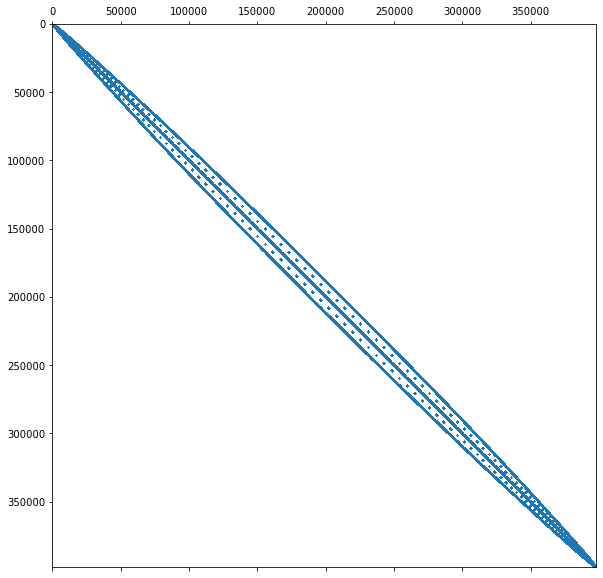

In [63]:
from scipy.sparse.csgraph import reverse_cuthill_mckee

prcm = reverse_cuthill_mckee(A)
row = np.arange(3*M)
col = prcm
P = sp.coo_matrix((np.ones(3*M), (row, col)), shape=(3*M,3*M))
plt.figure(figsize = (10,10))
plt.spy(P@A@P.T, markersize = 0.5)

## utilize iterative solver

In [64]:
from scipy.sparse.linalg import qmr, bicgstab

In [65]:
%%time
#x, info = qmr(A, b, maxiter = 2000)
x, info = bicgstab(A,b, maxiter = 2000)
print(info, 'if 0 yes')

0 if 0 yes
CPU times: user 1min 57s, sys: 1.91 s, total: 1min 59s
Wall time: 15 s


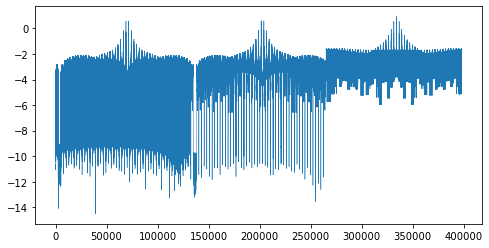

In [66]:
plt.figure(figsize = (8,4));
plt.plot(np.log10(np.abs(x)), linewidth = 0.5)

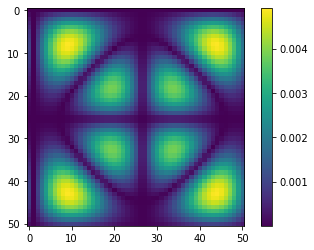

In [67]:
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F');
Ez = x[2*M:3*M].reshape(N, order = 'F');

plt.imshow(np.abs(Ex[:,12,:]))
plt.colorbar()

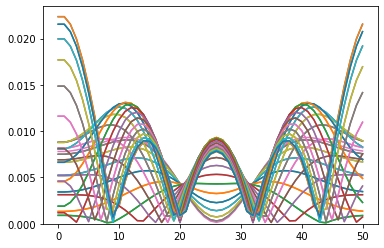

In [68]:
plt.figure();
for i in range(N[0]):
    plt.plot(np.abs(Ez[i,:,12]))
plt.ylim(ymin = 0)
plt.show()

(397953, 397953)


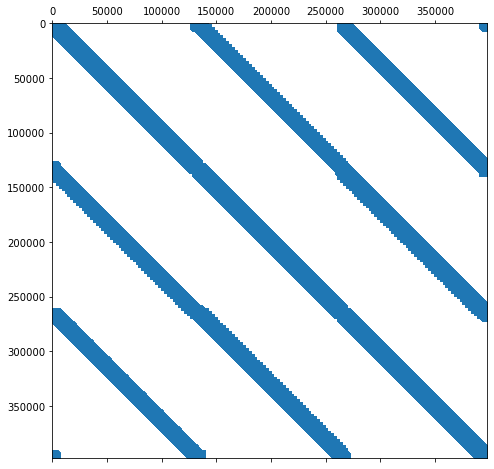

In [32]:
print(A.shape)
plt.figure(figsize = (8,8))
plt.spy(A)

In [19]:
#try solving with pardiso
# pardiso doesn't even really work with this FDFD matrix, which is odd...honestly very very odd

## current matrix is all real and indefinite, but the solve 
## preconditioning the lu solver is great, but it's not life-changing...how do we make the factorization life-changing

# with no pml, curl curl e is symmetric
pSolve = pardisoSolver(A, mtype=-2)



In [ ]:
# %%time
# pSolve.factor()

In [ ]:
# %%time
# x0 = pSolve.solve(P@np.imag(b))
# x0= P.T@x0
# plt.plot(np.abs(x0))
# plt.figure()
# Ex = np.reshape(x0[0:M],N)



In [ ]:
#plt.imshow(np.abs(Ex[:,:,0]))

In [ ]:
#lt.figure(figsize = (10,5))
plt.plot(np.abs(x0))
plt.plot(np.abs(x), 'x-', markersize = 1, alpha = 0.2)

In [ ]:
print(dir(pardisoSolver))

In [ ]:
for index, val in enumerate(pSolve.iparm):
    print(index, val)